## Naive Bayes on Political Text

In this notebook we use Naive Bayes to explore and classify political data. See the `README.md` for full details.

In [2]:
import sqlite3
import nltk
import random
import numpy as np
from collections import Counter, defaultdict
import cursor

# Feel free to include your text patterns functions
#from text_functions_solutions import clean_tokenize, get_patterns

nltk.download('punkt')
nltk.download('stopwords')

In [3]:
convention_db = sqlite3.connect("2020_Conventions.db")
convention_cur = convention_db.cursor()

### Part 1: Exploratory Naive Bayes

We'll first build a NB model on the convention data itself, as a way to understand what words distinguish between the two parties. This is analogous to what we did in the "Comparing Groups" class work. First, pull in the text 
for each party and prepare it for use in Naive Bayes.  

In [93]:
# # View the first row of the 'conventions' table
# convention_cur.execute("SELECT * FROM conventions LIMIT 2;")
# row = convention_cur.fetchone()


In [12]:
convention_data = []

# Connect to the database and create a cursor
convention_conn = sqlite3.connect("2020_Conventions.db")
convention_cur = convention_conn.cursor()

# Query to get the speech text and party from the table
query_results = convention_cur.execute(
    '''
    SELECT text, party FROM conventions;
    '''
)

for row in query_results:
    text, party = row
    # Tokenize and clean the text (convert to lowercase and tokenize)
    tokens = nltk.word_tokenize(text.lower())
    cleaned_text = ' '.join(tokens)
    # Append to the data list
    convention_data.append([cleaned_text, party])

Let's look at some random entries and see if they look right. 

If that looks good, we now need to make our function to turn these into features. In my solution, I wanted to keep the number of features reasonable, so I only used words that occur at least `word_cutoff` times. Here's the code to test that if you want it. 

In [34]:
import string

word_cutoff = 5
tokens = [w for t, p in convention_data for w in t.split()]

word_dist = nltk.FreqDist(tokens)

stop_words = set(stopwords.words('english'))
punct    = set(string.punctuation)

feature_words = {
    word
    for word, count in word_dist.items()
    if count > word_cutoff    
        ## I added these extra conditions to be able to pass the assertion later on
       and word.isalpha()       
       and word not in stop_words  
       and word not in punct       
}

print(f"With cutoff {word_cutoff}, features: {len(feature_words)}")

With cutoff 5, features: 2236


In [35]:
def conv_features(text, fw):
    """
    Return a {word: True} dictionary for every word in *text*
    that is also in the feature-word set *fw*.  Each word is
    counted only once.

    Parameters
    ----------
    text : str
        Case-folded, cleaned text to inspect.
    fw   : set
        Feature-word set (words we care about).

    Returns
    -------
    dict
        Keys are the feature words found in *text*, values are True.
    """
    # Split the text into individual words and discard duplicates
    tokens_in_text = set(text.split())

    return {word: True for word in tokens_in_text if word in fw}


In [36]:
conv_features("donald is the president",feature_words)

{'president': True, 'donald': True}

In [37]:
assert(len(feature_words)>0)
assert(conv_features("donald is the president",feature_words)==
       {'donald':True,'president':True})
assert(conv_features("people are american in america",feature_words)==
                     {'america':True,'american':True,"people":True})

Now we'll build our feature set. Out of curiosity I did a train/test split to see how accurate the classifier was, but we don't strictly need to since this analysis is exploratory. 

In [38]:
featuresets = [(conv_features(text,feature_words), party) for (text, party) in convention_data]

In [39]:
random.seed(20220507)
random.shuffle(featuresets)

test_size = 500

In [40]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.494


In [41]:
classifier.show_most_informative_features(25)

Most Informative Features
                   china = True           Republ : Democr =     27.1 : 1.0
                   votes = True           Democr : Republ =     23.8 : 1.0
             enforcement = True           Republ : Democr =     21.5 : 1.0
                 destroy = True           Republ : Democr =     19.2 : 1.0
                freedoms = True           Republ : Democr =     18.2 : 1.0
                 climate = True           Democr : Republ =     17.8 : 1.0
                supports = True           Republ : Democr =     17.1 : 1.0
                   crime = True           Republ : Democr =     16.1 : 1.0
                   media = True           Republ : Democr =     15.8 : 1.0
                 beliefs = True           Republ : Democr =     13.0 : 1.0
               countries = True           Republ : Democr =     13.0 : 1.0
                 defense = True           Republ : Democr =     13.0 : 1.0
                  defund = True           Republ : Democr =     13.0 : 1.0

Write a little prose here about what you see in the classifier. Anything odd or interesting?

### My Observations

Based on my time listening to political commentary, some of these make sense (freedoms,defense,isis,religion) being associated with Republican and Climate and  Voter rights being associated with democrats. However there are some very generic words like countries,beliefs,supports which are associated with republicans , which to me points in some bias in how the data was either recorded,ingested or preprocessed as I think this time of imbalance - republicans being 13x more likely to say "supports" doesn't seem plausible



## Part 2: Classifying Congressional Tweets

In this part we apply the classifer we just built to a set of tweets by people running for congress
in 2018. These tweets are stored in the database `congressional_data.db`. That DB is funky, so I'll
give you the query I used to pull out the tweets. Note that this DB has some big tables and 
is unindexed, so the query takes a minute or two to run on my machine.

In [42]:
cong_db = sqlite3.connect("congressional_data.db")
cong_cur = cong_db.cursor()

In [48]:
results = cong_cur.execute(
        '''
           SELECT DISTINCT 
                  cd.candidate, 
                  cd.party,
                  tw.tweet_text
           FROM candidate_data cd 
           INNER JOIN tweets tw ON cd.twitter_handle = tw.handle 
               AND cd.candidate == tw.candidate 
               AND cd.district == tw.district
           WHERE cd.party in ('Republican','Democratic') 
               AND tw.tweet_text NOT LIKE '%RT%'
        ''')

tweet_results = list(results) # Just to store it, since the query is time consuming

Basically copied the workflow from the first section and just slotted in tweet_feature_words instead

In [58]:



tokens = [w for t, p in tweet_data for w in t.split()]

word_dist = nltk.FreqDist(tokens)

stop_words = set(stopwords.words('english'))
punct    = set(string.punctuation)

tweet_feature_words = {
    word
    for word, count in word_dist.items()
    if count > word_cutoff      # frequent enough…
       and word.isalpha()        # purely alphabetic…
       and word not in stop_words  # not a stop‑word…
       and word not in punct       # not just punctuation
}

print(f"With cutoff {word_cutoff}, features: {len(tweet_feature_words)}")

With cutoff 5, features: 40143


In [59]:
featuresets = [(conv_features(text,tweet_feature_words), party) for (text, party) in tweet_data]

In [62]:
len(featuresets)
random.seed(20220507)
random.shuffle(featuresets)

test_size = 20000

In [63]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.7719


There are a lot of tweets here. Let's take a random sample and see how our classifer does. I'm guessing it won't be too great given the performance on the convention speeches...

In [60]:
random.seed(20201014)

tweet_data_sample = random.choices(tweet_data,k=10)

In [70]:
tweet_data_sample[0]

['earlier today , i spoke on the house floor abt protecting health care for women and praised @ ppmarmonte for their work on the central coast . https : //t.co/wqgtrzt7vv',
 'Democratic']

Random sample makes sense to me, womens health care is central to the democratic ideology

In [71]:

for tweet, party in tweet_data_sample :
    features = conv_features(tweet, tweet_feature_words)  # Convert text to feature dict
    estimated_party = classifier.classify(features)    
    
    print(f"Here's our (cleaned) tweet: {tweet}")
    print(f"Actual party is {party} and our classifer says {estimated_party}.")
    print("")
    

Here's our (cleaned) tweet: earlier today , i spoke on the house floor abt protecting health care for women and praised @ ppmarmonte for their work on the central coast . https : //t.co/wqgtrzt7vv
Actual party is Democratic and our classifer says Democratic.

Here's our (cleaned) tweet: go tribe ! # rallytogether https : //t.co/0nxutfl9l5
Actual party is Democratic and our classifer says Democratic.

Here's our (cleaned) tweet: apparently , trump thinks it 's just too easy for students overwhelmed by the crushing burden of debt to pay off student loans # trumpbudget https : //t.co/ckyqo5t0qh
Actual party is Democratic and our classifer says Democratic.

Here's our (cleaned) tweet: we ’ re grateful for our first responders , our rescue personnel , our firefighters , our police , and volunteers who have been working tirelessly to keep people safe , provide much-needed help , while putting their own lives on the line . https : //t.co/ezpv0vmiz3
Actual party is Republican and our classifer

Now that we've looked at it some, let's score a bunch and see how we're doing.

In [74]:

# I had gpt assist with this section a bit as the template was a bit hard for me to decipher
parties = ['Republican', 'Democratic']
results = defaultdict(lambda: defaultdict(int))

for p in parties:
    for p1 in parties:
        results[p][p1] = 0

num_to_score = len(tweet_data)
random.shuffle(tweet_data)

for idx, (tweet, party) in enumerate(tweet_data):
    features = conv_features(tweet, tweet_feature_words)  # convert text to feature dict
    estimated_party = classifier.classify(features)        # classify
    results[party][estimated_party] += 1

    if idx > num_to_score:
        break


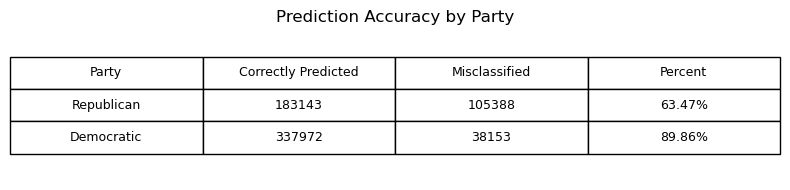


Total Accuracy: 78.40%


In [92]:
#Generated a table to show the results as I was curious about both the relative and absolute performance
summary_rows = []
for party in parties:
    correct = results[party][party]
    misclassified = sum(results[party][p] for p in parties if p != party)
    percent = correct / (correct + misclassified)
    summary_rows.append({
        "Party": party,
        "Correctly Predicted": correct,
        "Misclassified": misclassified,
        "Percent": percent
    })

df = pd.DataFrame(summary_rows)


fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table = ax.table(
    cellText=[[row["Party"], row["Correctly Predicted"], row["Misclassified"], f'{row["Percent"]:.2%}'] for _, row in df.iterrows()],
    colLabels=["Party", "Correctly Predicted", "Misclassified", "Percent"],
    cellLoc='center',
    loc='center'
)
table.scale(1, 2)
plt.title("Prediction Accuracy by Party")
plt.tight_layout()
plt.show()


correct = sum(results[p][p] for p in parties)
total = sum(sum(results[p].values()) for p in parties)
accuracy = correct / total if total > 0 else 0

print(f"\nTotal Accuracy: {accuracy:.2%}")

### Reflections

It's interesting but not surprising that a simple naive bayes classifier can do such a good job overall at classifying tweets as being from either republican or democrat. When I think about this task further it makes sense, political classification is one of the most basic text mining excersizes for the following reasons

#1 Both political parties virtue signal to their supporters by using key buzzwords

#2 We're doing binary classification, something more nuanced like spectrum analysis (far left, left, central, right , far right) would be more difficult as certain buzzwords wouldn't immediately give away the affiliation

#3 People who tweet about politicians are usually firm supporters about either party, in the same way that people who tweet about sports are usually sports fans, therefore they mirror their parties ideology and buzzwords, if the sample set was let's say annonymized survey conversations, this could be more difficult